# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 

Необходимо понимание процессов оттока клиентов. Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. 

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов.  

А именно: 

научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

проанализировать основные признаки, наиболее сильно влияющие на отток;

сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

#### Шаг 1. Загрузка данных. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="white")
from matplotlib import pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('...') # загрузил данные

#### Шаг 2. Исследовательский анализ данных (EDA).

In [3]:
data.info()
data.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,0,1,2,3,4
gender,1.000000,0.000000,0.000000,0.000000,1.000000
Near_Location,1.000000,1.000000,1.000000,1.000000,1.000000
Partner,1.000000,0.000000,1.000000,1.000000,1.000000
Promo_friends,1.000000,0.000000,0.000000,1.000000,1.000000
Phone,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,6.000000,12.000000,1.000000,12.000000,1.000000
Group_visits,1.000000,1.000000,0.000000,1.000000,0.000000
Age,29.000000,31.000000,28.000000,33.000000,26.000000
Avg_additional_charges_total,14.227470,113.202938,129.448479,62.669863,198.362265
Month_to_end_contract,5.000000,12.000000,1.000000,12.000000,1.000000


In [4]:
data.columns = data.columns.str.lower() # привел наименования столбцов к нижнему регистру

data['month_to_end_contract'] = data['month_to_end_contract'].astype(int) # изменил типы данных на корректные
data[['near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']] = \
data[['near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype(bool)

print('Количество дубликатов:', data.duplicated().sum(), '\n') # проверил наличие дубликатов
data.info()

Количество дубликатов: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   bool   
 2   partner                            4000 non-null   bool   
 3   promo_friends                      4000 non-null   bool   
 4   phone                              4000 non-null   bool   
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   bool   
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total    

Данные содержат 4000 записей о клиентах фитнес-центра. Пропусков, явных дубликатов не имеется. Изменены типы данных в month_to_end_contract на int; в near_location, partner, promo_friends, phone, group_visits, churn на bool; наименования столбцов - на корректные.

In [5]:
data.describe().T # описание данных

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.000000,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.000000,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.000000,0.963003,1.719574,2.510336,6.146783


In [6]:
churn_grouped = data.groupby('churn').mean() # вывел средние значения тех кто ушел/остался
churn_grouped.T

churn,False,True
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


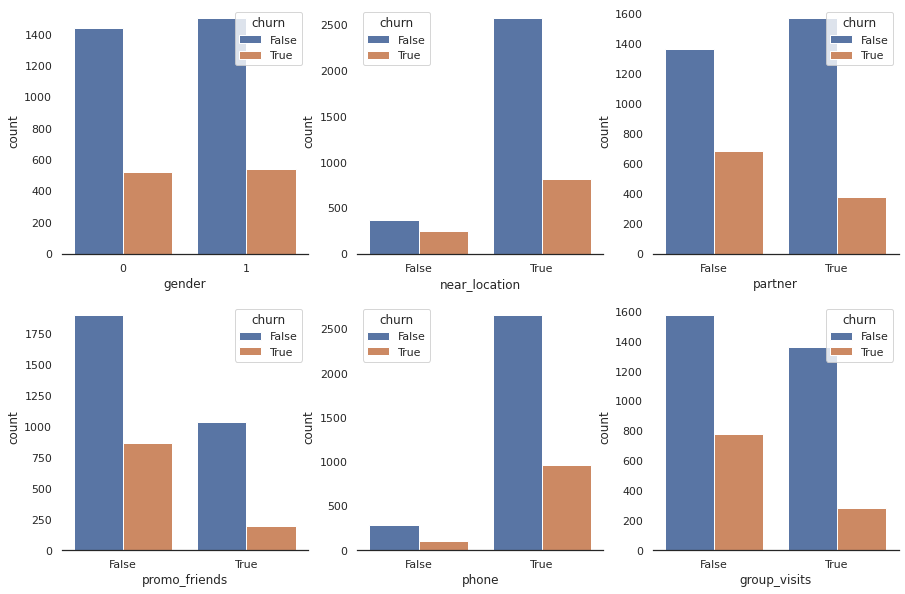

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) # столбчатые диаграммы по данным оттока
sns.despine(left=True)

sns.countplot(data = data, x = 'gender', hue='churn', ax=axes[0, 0])
sns.countplot(data = data, x = 'near_location', hue='churn', ax=axes[0, 1])
sns.countplot(data = data, x = 'partner', hue='churn', ax=axes[0, 2])
sns.countplot(data = data, x = 'promo_friends', hue='churn', ax=axes[1, 0])
sns.countplot(data = data, x = 'phone', hue='churn', ax=axes[1, 1])
sns.countplot(data = data, x = 'group_visits', hue='churn', ax=axes[1, 2])

fig.show()

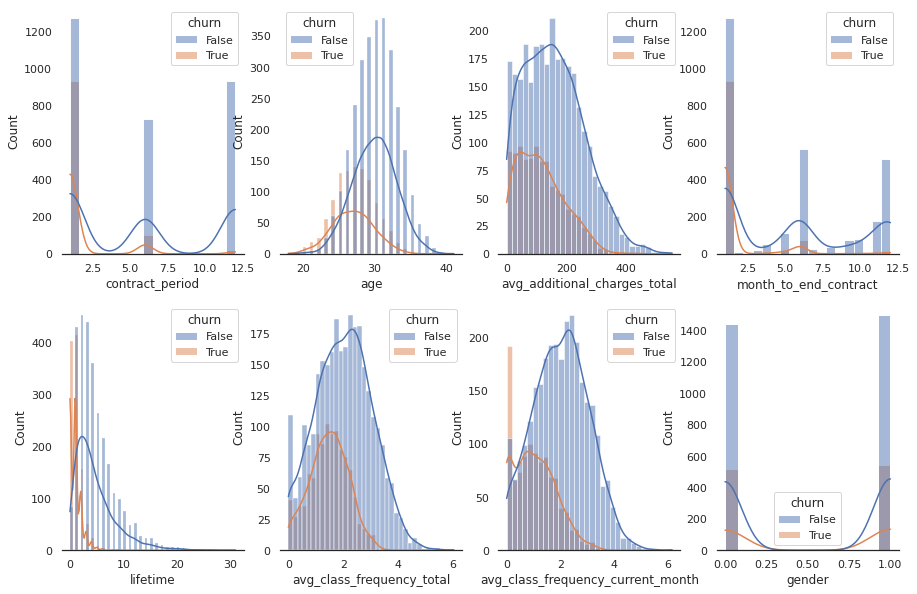

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10)) # распределения признаков по данным оттока
sns.despine(left=True)


sns.histplot(data = data, x = 'age', kde=True, hue='churn', ax=axes[0, 1])
sns.histplot(data = data, x = 'avg_additional_charges_total', kde=True, hue='churn', ax=axes[0, 2])
sns.histplot(data = data, x = 'month_to_end_contract', kde=True, hue='churn', ax=axes[0, 3])
sns.histplot(data = data, x = 'lifetime', kde=True, hue='churn', ax=axes[1, 0])
sns.histplot(data = data, x = 'avg_class_frequency_total', kde=True, hue='churn', ax=axes[1, 1])
sns.histplot(data = data, x = 'avg_class_frequency_current_month', kde=True, hue='churn', ax=axes[1, 2])
sns.histplot(data = data, x = 'gender', kde=True, hue='churn', ax=axes[1, 3]) # построил график для gender еще раз, чтобы не было пустого графика

fig.show()

Можно сделать вывод, что большую лояльность проявляют: те, кто живут поблизости, сотрудники компаний-партнеров, имеет длительный срок абонемента, старше 28 лет, воспользовался акцией "приведи друга", посещает групповые занятия.

Разницы в оттоке между мужчинами и женщинами нет

Большая доля попадает в отток: те, кто имеют краткосрочный абонемент, младше 28 лет, меньше тратит на дополнительные услуги, посещает центр реже двух раз в неделю. 

In [9]:
data.corr() # вывел матрицу корреляций

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


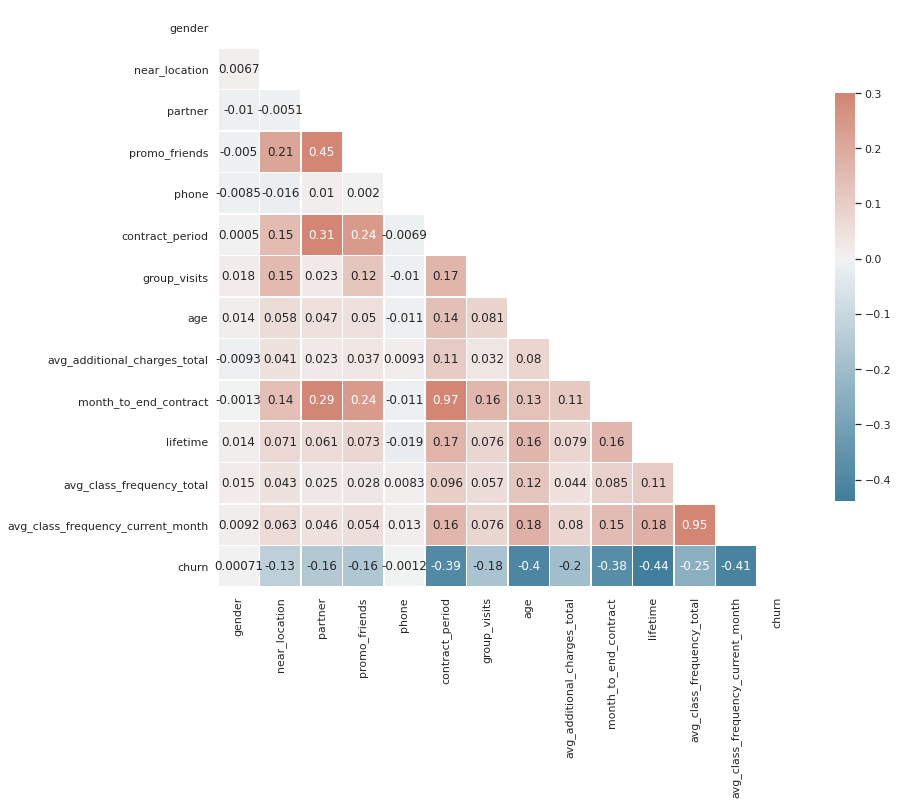

In [10]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool)) # построил тепловую карту для отображения матрицы корреляций

f, ax = plt.subplots(figsize=(13, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(data.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot = True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Наблюдается сильная зависимость между признаками - contract_period и month_to_end_contract, avg_class_frequency_current_month и avg_class_frequency_total.

In [11]:
model_data = data.drop('avg_class_frequency_total', axis=1) # убрал признаки, которые сильно коррелируют, чтобы избежать мультиколлинеарности
model_data = data.drop('month_to_end_contract', axis=1)

#### Шаг 3. Строим модель прогнозирования оттока клиентов.

In [12]:
X = model_data.drop('churn', axis=1) # разделил данные на матрицу признаков и целевые переменные
y = model_data['churn'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # выделил обучающую и валидационные выборки

In [13]:
scaler = StandardScaler() # создал объект класса StandardScaler
X_train_st = scaler.fit_transform(X_train) # обучил scaler, трансформировал матрицу обучающей выборки
X_test_st = scaler.transform(X_test) # стандартизировал матрицу признаков валидационной выборки

In [14]:
lr_model = LogisticRegression(solver='liblinear', random_state=0) # создал, обучил, использовал модели для прогнозов
lr_model.fit(X_train_st, y_train)
lr_prediction =  lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_st, y_train)
rf_prediction = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [15]:
def print_metrics(model): # объявил функцию для вывода значений метрик
    model.fit(X_train_st, y_train)
    y_pred = model.predict(X_test_st)
    print('Доля правильных ответов:', round(accuracy_score(y_test, y_pred), 2))
    print('Точность:', round(precision_score(y_test, y_pred), 2))
    print('Полнота:', round(recall_score(y_test, y_pred), 2), '\n')

In [16]:
print('Метрики логистической регрессии:', '\n')
print_metrics(lr_model)

print('Метрики случайного леса:', '\n')
print_metrics(rf_model)

Метрики логистической регрессии: 

Доля правильных ответов: 0.92
Точность: 0.85
Полнота: 0.83 

Метрики случайного леса: 

Доля правильных ответов: 0.91
Точность: 0.83
Полнота: 0.81 



Метрики имеют хорошие значения. Немного лучше показатели у логистической регрессии.

#### Шаг 4. Кластеризация клиентов.

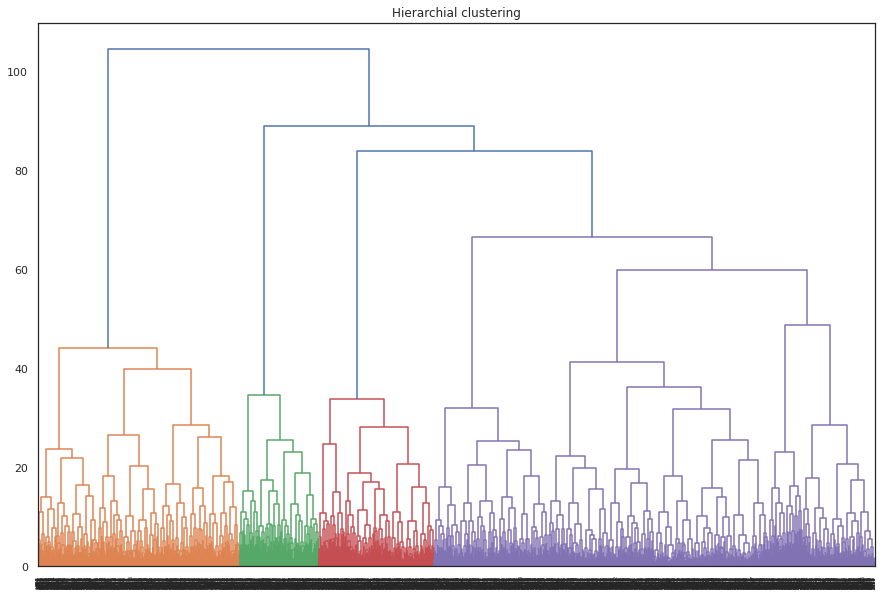

In [17]:
sc = StandardScaler() # создал объект класса scaler для стандартизации
X_sc = sc.fit_transform(data.drop('churn', axis=1)) # обучил объект класса scaler, преобразовал данные

linked = linkage(X_sc, method = 'ward') # сохранил таблицу связок между объектами, которую можно визуализировать как дендрограмму

plt.figure(figsize=(15, 10)) # построил дендрограмму
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show()

По количеству цветов на графике можно выделить 4 кластера. Определим число кластеров - 5 (по условию).

In [18]:
km = KMeans(n_clusters=5, random_state=0) # задал число кластеров, равное 5, зафиксировал значение random_state для воспроизводимости результата
labels = km.fit_predict(X_sc) # применил алгоритм к данным, сформировал вектор кластеров
data['cluster'] = labels # добавил столбец с индексами кластеров
data.head().T

,0,1,2,3,4
gender,1,0,0,0,1
near_location,True,True,True,True,True
partner,True,False,True,True,True
promo_friends,True,False,False,True,True
phone,False,True,True,True,True
contract_period,6,12,1,12,1
group_visits,True,True,False,True,False
age,29,31,28,33,26
avg_additional_charges_total,14.22747,113.202938,129.448479,62.669863,198.362265
month_to_end_contract,5,12,1,12,1


In [19]:
round(data.groupby('cluster').mean(), 2).T # вывел средние значения признаков для кластеров

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


Наиболее лояльные клиенты попали в кластеры 0 и 4. Средние значения признаков для кластеров подтверждают наблюдения, полученные на шаге 2.

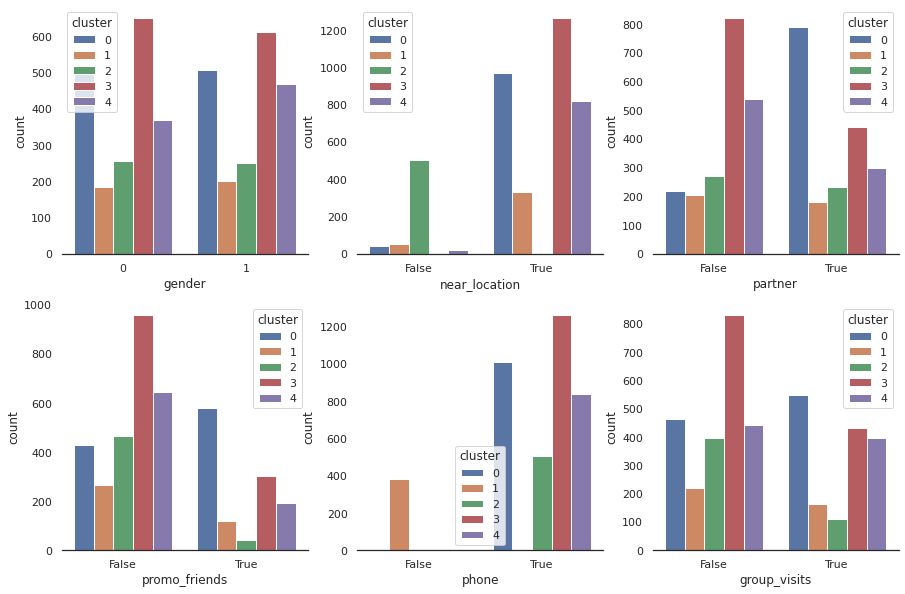

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) # столбчатые диаграммы для кластеров
sns.despine(left=True)

sns.countplot(data = data, x = 'gender', hue='cluster', ax=axes[0, 0])
sns.countplot(data = data, x = 'near_location', hue='cluster', ax=axes[0, 1])
sns.countplot(data = data, x = 'partner', hue='cluster', ax=axes[0, 2])
sns.countplot(data = data, x = 'promo_friends', hue='cluster', ax=axes[1, 0])
sns.countplot(data = data, x = 'phone', hue='cluster', ax=axes[1, 1])
sns.countplot(data = data, x = 'group_visits', hue='cluster', ax=axes[1, 2])

fig.show()

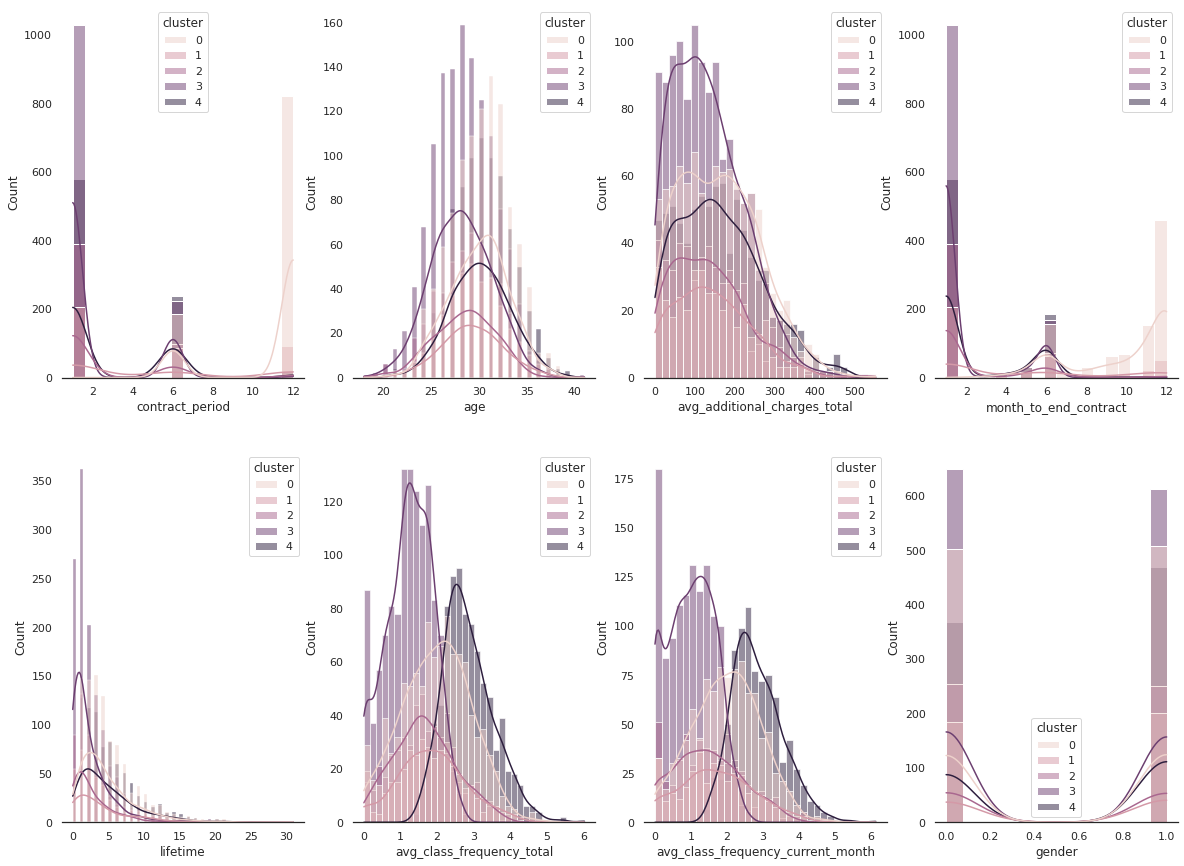

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15)) # распределения признаков по кластерам
sns.despine(left=True)

sns.histplot(data = data, x = 'contract_period', kde=True, hue='cluster', ax=axes[0, 0])
sns.histplot(data = data, x = 'age', kde=True, hue='cluster', ax=axes[0, 1])
sns.histplot(data = data, x = 'avg_additional_charges_total', kde=True, hue='cluster', ax=axes[0, 2])
sns.histplot(data = data, x = 'month_to_end_contract', kde=True, hue='cluster', ax=axes[0, 3])
sns.histplot(data = data, x = 'lifetime', kde=True, hue='cluster', ax=axes[1, 0])
sns.histplot(data = data, x = 'avg_class_frequency_total', kde=True, hue='cluster', ax=axes[1, 1])
sns.histplot(data = data, x = 'avg_class_frequency_current_month', kde=True, hue='cluster', ax=axes[1, 2])
sns.histplot(data = data, x = 'gender', kde=True, hue='cluster', ax=axes[1, 3])

fig.show()

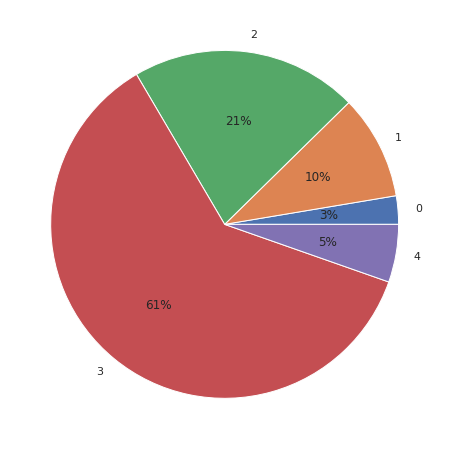

In [22]:
churn_share = data.query('churn==1').groupby('cluster')['churn'].count() / data.query('churn==1')['churn'].count()

plt.figure(figsize=(8, 8))
plt.pie(churn_share.values, labels=churn_share.index, autopct='%.0f%%')
plt.show() 

In [23]:
round(data.groupby('cluster').mean(), 2).T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


Во всех кластерах практически одинаковое количество мужчин и женщин, возраст примерно одинаковый.

Наименьший отток в кластерах 0 и 4.

Никто из кластера 2 не проживает рядом с фитнес-центром.

В кластер 0 попали следующие клиенты:

    живут рядом с фитнес - центром;
    сотрудники компаний-партнеров;
    имеют годовые абонементы;
    много тратят на дополнительные услуги
    посещают занятия в среднем дважды в неделю;
    чаще посещающие групповые занятия.

В кластер 0 попали те, кто наиболее заинтересован в систематических тренировках, целенаправленно посещает фитнес-центр.

Кластер 1:

    живут рядом с фитнес - центром;
    срок абонемента в среднем примерно 5 месяцев;
    меньше сотрудников компаний-партнеров, участников акции "приведи друга";
    реже посещающие групповые занятия;
    меньше показатель посещаемости (в том числе групповых занятий);
    достаточно высокая доля оттока.

В целом кластер 1 схож по характеристикам с кластером 0, но можно отметить меньшую заинтересованность в услугах центра
либо желание сэкономить (абонемент на меньший период, меньше затраты на дополнительные услуги, большой, но не самый высокий отток).

Кластер 2:

    живут далеко;
    значительная доля сотрудников компаний-партнеров;
    почти нет участников акции "приведи друга";
    короткие абонементы;
    наименьший показатель по групповым занятиям;
    реже 2 раз в неделю посещают занятия;
    высокая доля оттока.

Можно предположить, что в кластер 2 попали те, кто решил попровать пользоваться услугами фитнес-центра по партнерской программе,
чтобы сэкономить, но намерений систематически тренироваться не имеет (в том числе по причине удаленности центра).

Кластер 3:

    живут рядом;
    краткосрочные абонементы;
    низкая посещаемость;
    самая высокая доля оттока.
    
Характеристики кластера 3 схожи с кластером 2, разница - близость проживания. Можно предположить, что это те, кто решил
воспользоваться фитнес-центром поблизости, чтобы попробовать тренировки или без намерений систематического посещения.
    
Кластер 4:

Имеет незначительный отток. Схож с кластером 0, разница - меньшая доля сотрудников компаний-партнеров, участников "приведи друга", небольшой срок абонемента. При этом попавшие в кластер чаще посещают центр.

#### Шаг 5. Выводы и базовые рекомендации по работе с клиентами.

В ходе исследования проведен анализ данных посетителей фитнес-центра. При этом построены модели прогнозирования оттока клиентов при помощи моделей логичестическая регрессия и случайный лес. По показателям метрик accurancy, precision и recall можно сказать, что обе модели хорошо показывают себя в прогнозировании оттока. При этом лучше метрики показывает логистическая регрессия.

Проведена кластеризация посетителей, которые разделены на 5 кластеров, что позволило разделить клиентов по лояльности. Сформированы типичные портреты посетителей, выделены наиболее яркие группы и их характеристики. Выделены признаки, влияющие на отток.

Рекомендации:

В любом случае целевая аудитория фитнес-центра - те, кто живет рядом. На них следует сосредоточить усилия.

Наименьший отток - у пользователей годовых абонементов. Таким образом, следует создать заинтересованность (цена, дополнительные опции) в приобретении годовых контрактов.

В кластере 0 наименьший отток и самая высокий показатель пользователей партнерских программ и акции "приведи друга". Можно также  рекомендовать расширить сеть партнеров, найти дополнительные каналы распространения информации среди работников имеющихся партнеров. С учетом коэффициента корреляции (0,45) между partner и promo_friends и средних значений признаков для кластеров, можно предположить, что акция имеет неплохое распространение внутри компаний-партнеров.

<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проверке**

Спасибо за отличную работу. Критичных комментариев нет. Думаю, такой проект можно смело принимать с первого раза.
    
Если что-то пропустил или остались вопросы, оставляю для обратной связи телеграм @kriill

Желаю удачи в дальнейшей учебе!

</div>